In [169]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18
import torch
import random
import torch.nn.functional as F
from torch import nn, optim
import numpy as np
from sklearn.manifold import TSNE

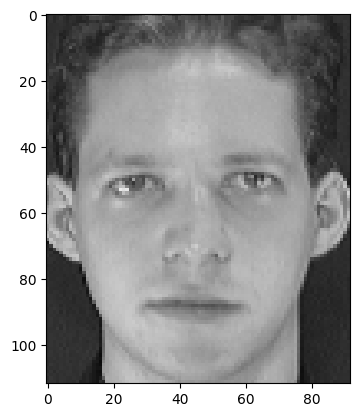

In [170]:
face = Image.open('faces/s1/1.pgm').convert('RGB')
plt.imshow(face)

In [171]:
class FaceDataset():
    def __init__(self, img_data, transform):
        self.img_data = img_data
        self.transform = transform
 
    def __getitem__(self, idx):
        img0_tuple = random.choice(self.img_data.imgs)
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                img1_tuple = random.choice(self.img_data.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_tuple = random.choice(self.img_data.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("RGB")
        img1 = img1.convert("RGB")

        input_img1 = self.transform(img0)
        input_img2 = self.transform(img1)
        label =  torch.tensor(float(img1_tuple[1] != img0_tuple[1]), dtype=torch.float32).unsqueeze(0)
        return input_img1, input_img2, label
    
    def __len__(self):
        return len(self.img_data.imgs)

In [172]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                transforms.Resize((100,100)),
                                transforms.ToTensor()
                                ])

In [173]:
faces_dataset_folder = datasets.ImageFolder('faces', 
                                     transform=transform)
len(faces_dataset_folder.classes)

40

In [174]:
faces_dataset = FaceDataset(img_data=faces_dataset_folder, transform=transform)

In [175]:
len(faces_dataset)

400

In [176]:

BATCH_SIZE = 32

train_dataset, test_dataset = random_split(dataset=faces_dataset,
                                           lengths=[0.7, 0.3])

train_dataloader = DataLoader(dataset=train_dataset,
                                batch_size=BATCH_SIZE)

test_dataloader = DataLoader(dataset=test_dataset, 
                             shuffle=False,
                             batch_size=1)

In [177]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
      return loss_contrastive

In [178]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn = resnet18(pretrained=True)
        self.cnn.fc = nn.Linear(self.cnn.fc.in_features, 128)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
    def forward_once(self, x):
        return self.cnn(x)

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2 


In [179]:
EPOCHS = 20

model = SiameseNetwork()
# for param in model.cnn.parameters():
#   param.requires_grad = False
# for param in model.cnn.fc.parameters():
#   param.requires_grad = True
loss_fn = ContrastiveLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.001)

c:\Users\Дарья\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Дарья\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [180]:
counter = []
loss_history = [] 
iteration_number= 0

for epoch in range(EPOCHS+1):

    for img0, img1, label in train_dataloader:
        optimizer.zero_grad()
        output1, output2 = model(img0, img1)
        loss = loss_fn(output1, output2, label)
        loss.backward()
        optimizer.step()

    if epoch % 5 == 0 :
        print(f"Epoch {epoch}\n Current loss {loss.item()}\n")
        iteration_number += 10

        counter.append(iteration_number)
        loss_history.append(loss.item())


Epoch 0
 Current loss 0.7586696147918701

Epoch 5
 Current loss 0.23058386147022247

Epoch 10
 Current loss 0.126666858792305

Epoch 15
 Current loss 0.14679096639156342

Epoch 20
 Current loss 0.1429213136434555



In [181]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

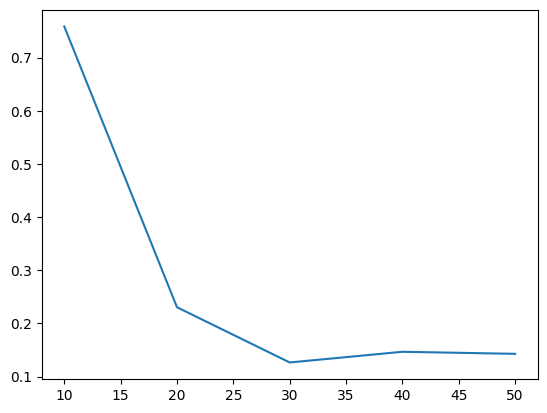

In [182]:
show_plot(counter, loss_history)

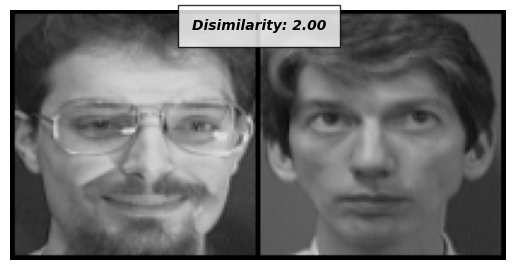

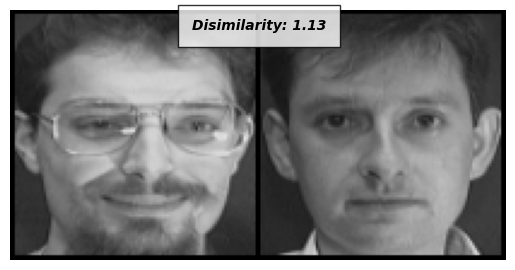

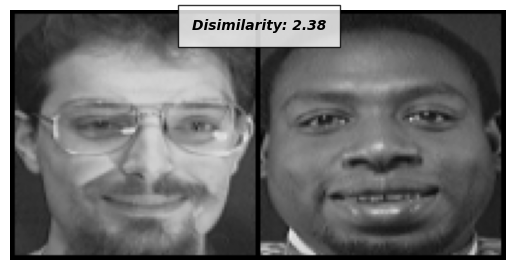

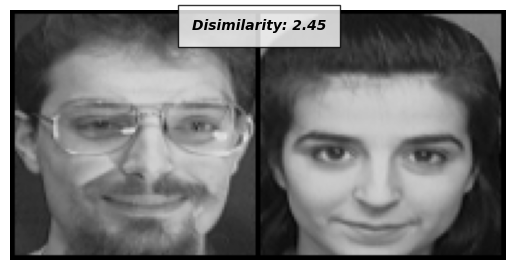

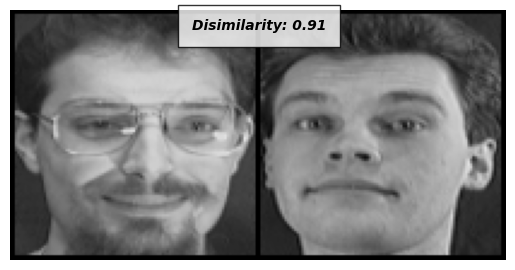

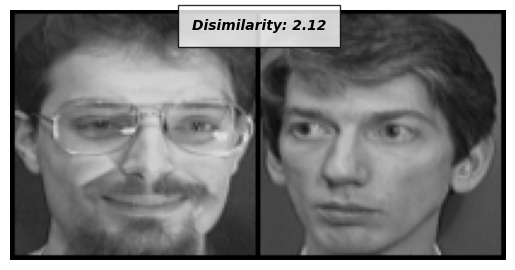

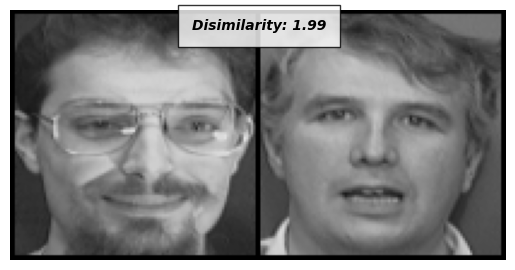

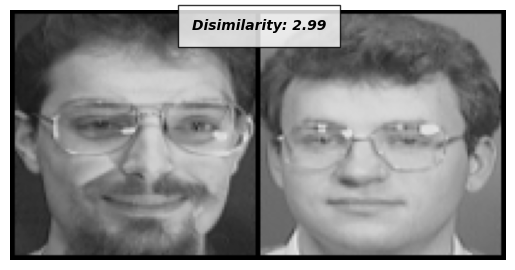

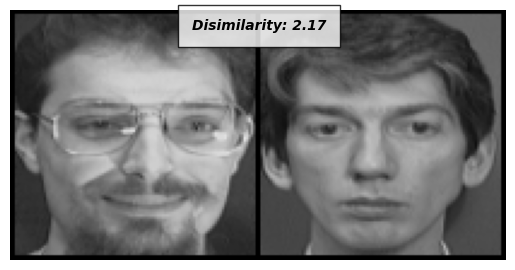

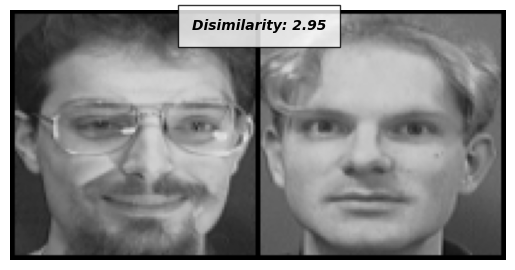

In [198]:
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    _, x1, label2 = next(dataiter)

    concatenated = torch.cat((x0, x1), 0)
    
    output1, output2 = model(x0, x1)
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(make_grid(concatenated), f'Disimilarity: {euclidean_distance.item():.2f}')

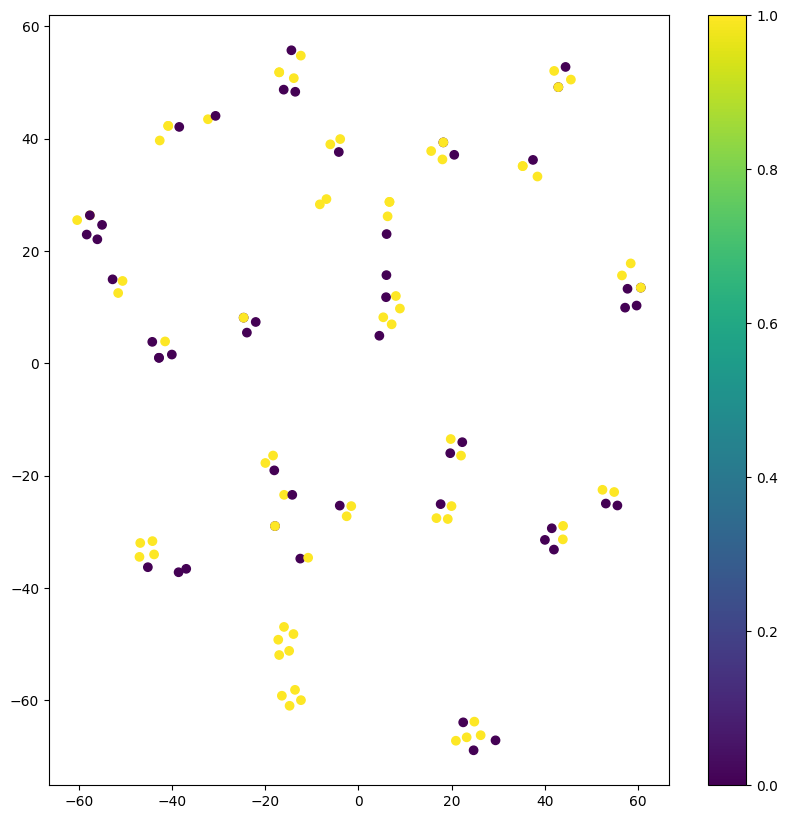

In [184]:
def visualize_tsne(model, test_loader):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for img, img2, label in test_loader:
            output = model.forward_once(img)
            embeddings.append(output)
            labels.append(label)
    
    embeddings = torch.cat(embeddings).numpy()
    labels = torch.cat(labels).numpy()
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=5)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(10, 10))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels)
    plt.colorbar()
    plt.show()

visualize_tsne(model, test_dataloader)